### Higgs Boson Dataset Model

https://www.kaggle.com/c/higgs-boson

In [127]:
import pandas as pd
import numpy as np
from numpy.random import seed

from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras.layers import Dense, Layer, Input, BatchNormalization, Dropout, ReLU
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

# hyper-parameter tuning
import optuna

# for plotting
import matplotlib.pyplot as plt

In [32]:
print(tf.__version__)

# Voglio essere sicuro della versione TF
assert tf.__version__ >= "2.3"

2.3.2


In [33]:
SEED = 1234

# to make it more deterministic
seed(SEED)
tf.random.set_seed(SEED)

In [34]:
# this is the code to setup the Strategy to work on multiple GPUs
# we will set anyway as if we have multiple GPU
DEVICE = "GPU"

if DEVICE == "GPU":
    n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", n_gpu)
    
    if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

Num GPUs Available:  1
Standard strategy for GPU...
REPLICAS: 1


In [35]:
# globals
BATCH_SIZE = 512



### Read train dataset and split in train, validation

In [39]:
orig_data = pd.read_csv('training.csv')

orig_data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [40]:
# eventID can be dropped, together weight
cols = list(orig_data.columns)

to_drop = ['EventId', 'Weight']

cols = [c for c in cols if c not in to_drop]
TARGET = 'Label'

features = [c for c in cols if c != TARGET]

N_FEATURES = len(features)

# seleziono solo le colonne che voglio
data = orig_data[cols]

In [41]:
data.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,s
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,b
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,b
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,b
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,b


In [42]:
# split in train, valid

# shuffle
data = data.sample(frac = 1.)

TRAIN_FRAC = 0.9
NUM_TRAIN = int(data.shape[0] * TRAIN_FRAC)

df_train = data[0:NUM_TRAIN]
df_valid = data[NUM_TRAIN:]

print('Number of train samples:', df_train.shape[0])
print('Number of validation samples:', df_valid.shape[0])

Number of train samples: 225000
Number of validation samples: 25000


In [43]:
# prepariamo X, y per train, validation

# X

X_train = df_train[features].values
X_valid = df_valid[features].values

y_train = df_train[TARGET].values
y_valid = df_valid[TARGET].values

In [44]:
# in questo modo elimino i -999

imp = SimpleImputer(missing_values=-999.00, strategy='median')

X_train = imp.fit_transform(X_train)
X_valid = imp.fit_transform(X_valid)

In [45]:
# applichiamo QuantileTransformer ad X

qt = QuantileTransformer(output_distribution = 'normal', n_quantiles = 10000)

X_train_qt = qt.fit_transform(X_train)

X_valid_qt = qt.fit_transform(X_valid)

### vediamo distribuzione prima e dopo

In [124]:
def plot_histo_features(X):
    plt.figure(figsize = (20, 10))

    for col in range(N_FEATURES):
        plt.subplot(3, 10, col + 1)
        plt.title(str(col + 1))
        plt.hist(X[col], bins=32)
        plt.grid(True)
    
    plt.show()

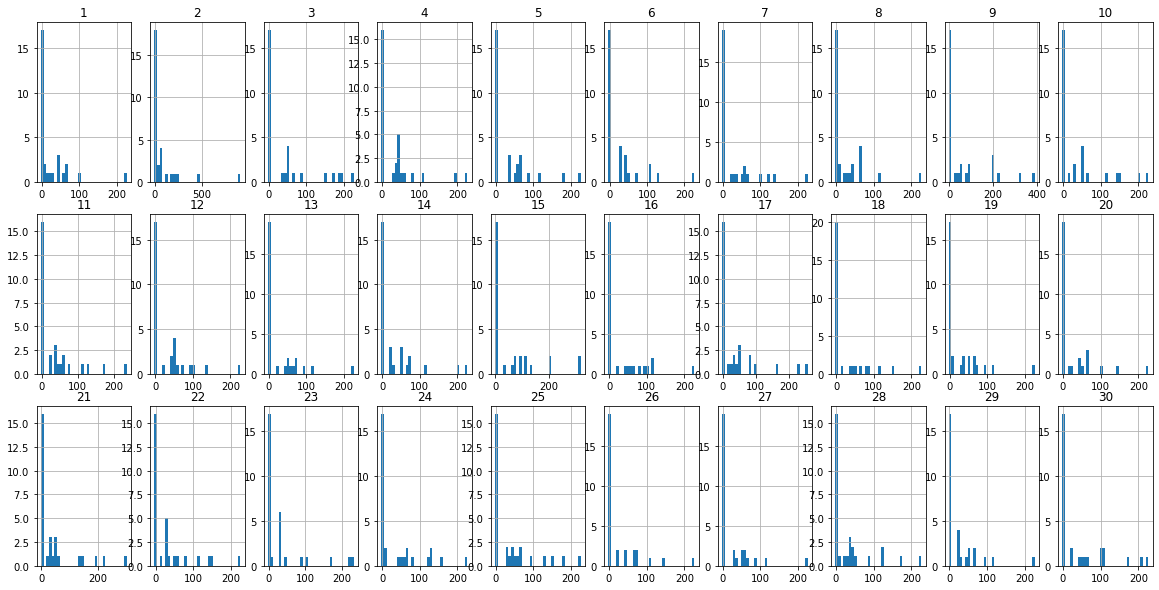

In [125]:
plot_histo_features(X_train)

### dopo la QuantileTransformation

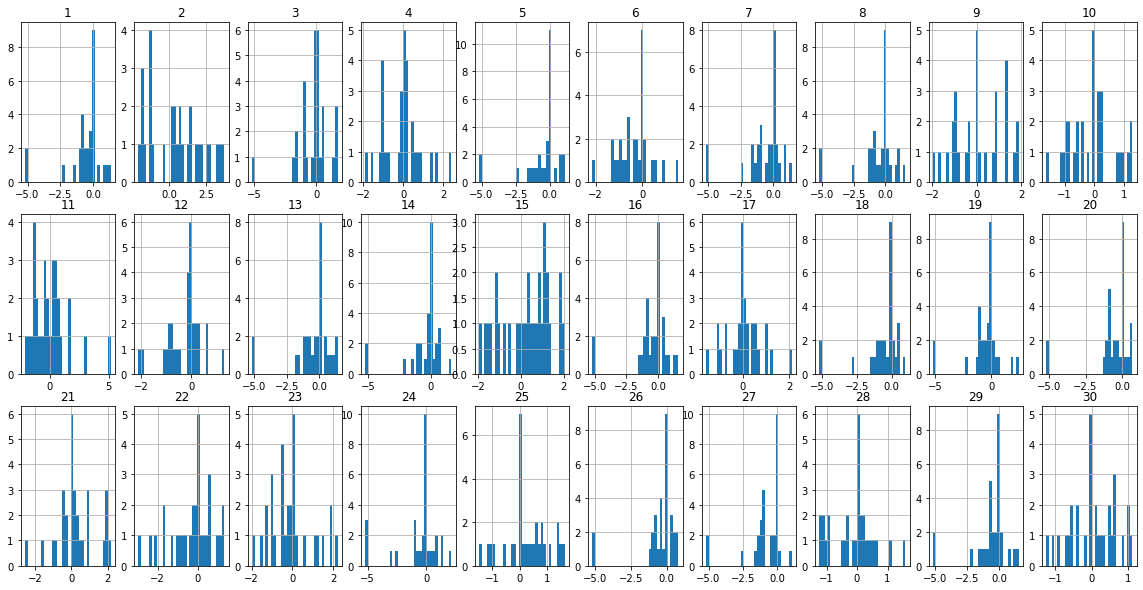

In [126]:
plot_histo_features(X_train_qt)

In [48]:
# processo le label

le = LabelEncoder()

le.fit(y_train)

y_train_enc = le.transform(y_train)
y_valid_enc = le.transform(y_valid)

In [49]:
# OK: signal = 1, b = 0

# OK, a questo punto X_train_qt ed X_valid_qt hanno media zero e std = 1 OK

In [157]:
# beh... non sono sicuro... sono ritornato a Layer
# con model posso fare però il summary

# in questo modo funziona la creazione di un ResidualBlock

class MyResidualBlock(Layer):
    def __init__(self, units, dropout_rate1, dropout_rate2, name=''):
        super().__init__(name=name)
        self.units = units
        # inner dropout rate
        self.dropout_rate1 = dropout_rate1
        # outer dropout rate
        self.dropout_rate2 = dropout_rate2
        
        self.bn1 = BatchNormalization()
        self.dense1 = Dense(units=self.units, activation="relu")
        self.dropout1 = Dropout(self.dropout_rate1)
        self.dense2 = Dense(units=self.units, activation=None)
        self.dropout2 = Dropout(self.dropout_rate2)
    
    def call(self, inputs):
        # print('input shape:', inputs.shape)
        
        x = self.bn1(inputs)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        
        # sommando implemento il residual block
        out = self.dropout2(x) + inputs
        
        return out

In [158]:
# let's test it
block = MyResidualBlock(30, 0.3, 0.3, name='rb1')

_ = block(tf.zeros([1, 30]))

# block.summary()

In [173]:
# qui definisco il modello completo

class ModelResidual(Model):
    def __init__(self, n_blocks, hidden_drop, **kwargs):
        super().__init__(**kwargs)
        self.n_blocks = n_blocks
        
        # first linear
        self.f_linear = Dense(N_FEATURES, activation=None)
        
        self.hidden = []
        
        # aggiunge la parte di residual block
        for l in range(self.n_blocks):
            self.hidden.append(MyResidualBlock(N_FEATURES, hidden_drop, 0, name='rb' + str(l)))
        
        # final layer
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.out = Dense(1, activation="sigmoid")
        
    def call(self, inputs):
        x = inputs
        
        # first linear
        x = self.f_linear(x)
        
        for l in range(self.n_blocks):
            x = self.hidden[l](x)
        
        # aggiunto BN finale
        x = self.bn(x)
        # aggiunto relu
        x = self.relu(x)
        out = self.out(x)
        
        return out

In [174]:
# for optuna

def build_model(n_blocks, hidden_drop, lr=0.001):
    model = ModelResidual(n_blocks = n_blocks, hidden_drop = hidden_drop)
    
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC'])
    
    return model

In [175]:
with strategy.scope():
    # il valore indicato da Optuna
    model = build_model(n_blocks = 8, hidden_drop = 0.2)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [176]:
model.layers

In [163]:
EPOCHS = 100


es_cbk = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=16,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(X_train_qt, y_train_enc,  epochs = EPOCHS, validation_data = (X_valid_qt, y_valid_enc), batch_size = BATCH_SIZE,
                   callbacks = [es_cbk])

Epoch 1/100
440/440 [==============================] - 4s 9ms/step - loss: 0.4529 - auc: 0.8470 - val_loss: 0.3894 - val_auc: 0.8913
Epoch 2/100
440/440 [==============================] - 3s 8ms/step - loss: 0.3936 - auc: 0.8884 - val_loss: 0.3746 - val_auc: 0.8996
Epoch 3/100
440/440 [==============================] - 3s 8ms/step - loss: 0.3842 - auc: 0.8941 - val_loss: 0.3675 - val_auc: 0.9039
Epoch 4/100
440/440 [==============================] - 4s 8ms/step - loss: 0.3782 - auc: 0.8976 - val_loss: 0.3659 - val_auc: 0.9053
Epoch 5/100
440/440 [==============================] - 3s 8ms/step - loss: 0.3744 - auc: 0.8997 - val_loss: 0.3638 - val_auc: 0.9052
Epoch 6/100
440/440 [==============================] - 3s 8ms/step - loss: 0.3717 - auc: 0.9013 - val_loss: 0.3676 - val_auc: 0.9058
Epoch 7/100
440/440 [==============================] - 3s 8ms/step - loss: 0.3693 - auc: 0.9026 - val_loss: 0.3596 - val_auc: 0.9081
Epoch 8/100
440/440 [==============================] - 3s 8ms/step - 

In [164]:
def plot_loss():
    plt.figure(figsize=(9, 6))
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss, label = 'loss')
    plt.plot(val_loss, label = 'validation loss')
    plt.legend(loc = 'upper right')
    plt.grid();
    plt.show()

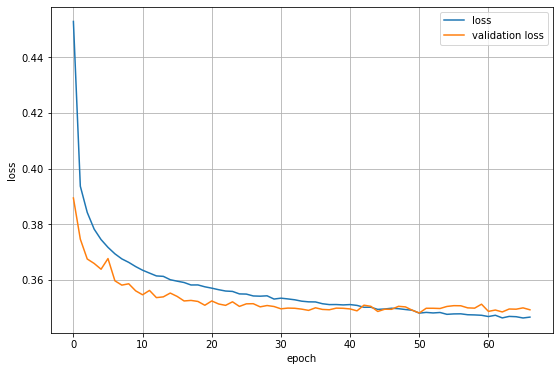

In [165]:
plot_loss()

In [166]:
def plot_auc():
    plt.figure(figsize=(9, 6))
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(auc, label = 'AUC')
    plt.plot(val_auc, label = 'validation AUC')
    plt.legend(loc = 'lower right')
    plt.grid();
    plt.show()

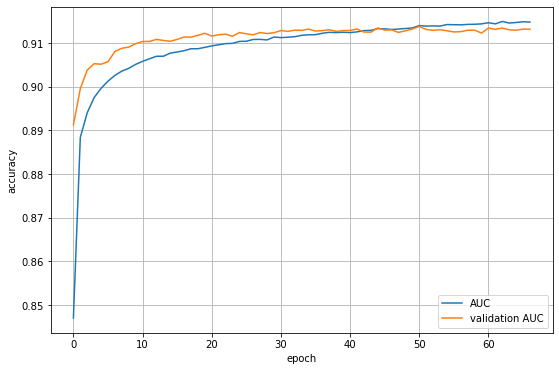

In [167]:
plot_auc()

In [168]:
model.summary()

Model: "model_residual_205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rb0 (MyResidualBlock)        multiple                  1980      
_________________________________________________________________
rb1 (MyResidualBlock)        multiple                  1980      
_________________________________________________________________
rb2 (MyResidualBlock)        multiple                  1980      
_________________________________________________________________
rb3 (MyResidualBlock)        multiple                  1980      
_________________________________________________________________
rb4 (MyResidualBlock)        multiple                  1980      
_________________________________________________________________
rb5 (MyResidualBlock)        multiple                  1980      
_________________________________________________________________
rb6 (MyResidualBlock)        multiple           

### adding Optuna

In [177]:
def objective(trial):
    
    # strategy for search (parameter to tune)
    n_blocks = trial.suggest_int("n_blocks", 1, 10)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    h_drop = trial.suggest_uniform("hf", 0, 0.5)
    
    with strategy.scope():
        model = build_model(n_blocks = n_blocks, hidden_drop = h_drop, lr=lr)
    
    es_cbk = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=16,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=False)

    history = model.fit(X_train_qt, y_train_enc,  epochs = EPOCHS, validation_data = (X_valid_qt, y_valid_enc), batch_size = BATCH_SIZE,
                   callbacks = [es_cbk], verbose=0)
    
    
    # no need to re-evaluate I can get best vaL-auc from history
    score = np.max(history.history['val_auc'])
    
    return score

In [ ]:
# the sqllite file has name resnet1.db

study_name = "resnet1"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(study_name=study_name, storage=storage_name, direction='maximize')

study.optimize(objective, n_trials=100)

[I 2021-07-24 15:25:09,018] A new study created with name: resnet1
[I 2021-07-24 15:29:51,530] Trial 0 finished with value: 0.9135973453521729 and parameters: {'n_blocks': 9, 'lr': 0.0006896307065129192, 'hf': 0.41355750583418716}. Best is trial 0 with value: 0.9135973453521729.


Epoch 00080: early stopping


[I 2021-07-24 15:33:55,365] Trial 1 finished with value: 0.9042432904243469 and parameters: {'n_blocks': 5, 'lr': 3.204063549782856e-05, 'hf': 0.36756866780275044}. Best is trial 0 with value: 0.9135973453521729.
[I 2021-07-24 15:38:55,307] Trial 2 finished with value: 0.9086316227912903 and parameters: {'n_blocks': 7, 'lr': 7.961517004648136e-05, 'hf': 0.48573758538891226}. Best is trial 0 with value: 0.9135973453521729.
[I 2021-07-24 15:45:12,848] Trial 3 finished with value: 0.9132937788963318 and parameters: {'n_blocks': 10, 'lr': 0.0001846874943053899, 'hf': 0.34351402094675076}. Best is trial 0 with value: 0.9135973453521729.
[I 2021-07-24 15:48:02,951] Trial 4 finished with value: 0.9117178320884705 and parameters: {'n_blocks': 4, 'lr': 0.00029116996376259233, 'hf': 0.22258383197088677}. Best is trial 0 with value: 0.9135973453521729.


Epoch 00078: early stopping


[I 2021-07-24 15:52:09,503] Trial 5 finished with value: 0.9133695363998413 and parameters: {'n_blocks': 5, 'lr': 0.0007889793177254955, 'hf': 0.40194015550507084}. Best is trial 0 with value: 0.9135973453521729.
[I 2021-07-24 15:56:40,244] Trial 6 finished with value: 0.9117658734321594 and parameters: {'n_blocks': 6, 'lr': 0.00010174453590162248, 'hf': 0.22604325517585838}. Best is trial 0 with value: 0.9135973453521729.
[I 2021-07-24 15:58:52,986] Trial 7 finished with value: 0.9083041548728943 and parameters: {'n_blocks': 1, 'lr': 0.0001129952315470154, 'hf': 0.21851763929792745}. Best is trial 0 with value: 0.9135973453521729.
[I 2021-07-24 16:03:50,198] Trial 8 finished with value: 0.8989878296852112 and parameters: {'n_blocks': 7, 'lr': 1.711211590925698e-05, 'hf': 0.21328621758683203}. Best is trial 0 with value: 0.9135973453521729.
[I 2021-07-24 16:09:27,167] Trial 9 finished with value: 0.9134264588356018 and parameters: {'n_blocks': 10, 'lr': 0.0010957208007364469, 'hf': 0.4

Epoch 00088: early stopping


[I 2021-07-24 16:11:48,229] Trial 10 finished with value: 0.9131982326507568 and parameters: {'n_blocks': 9, 'lr': 0.008079136887698393, 'hf': 0.04922890921648426}. Best is trial 0 with value: 0.9135973453521729.


Epoch 00039: early stopping


[I 2021-07-24 16:16:04,122] Trial 11 finished with value: 0.9144378304481506 and parameters: {'n_blocks': 10, 'lr': 0.001730766967138896, 'hf': 0.48756993673642496}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00067: early stopping


[I 2021-07-24 16:20:10,021] Trial 12 finished with value: 0.9135346412658691 and parameters: {'n_blocks': 9, 'lr': 0.004291201989042985, 'hf': 0.43751596515406177}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00069: early stopping


[I 2021-07-24 16:23:06,880] Trial 13 finished with value: 0.9135266542434692 and parameters: {'n_blocks': 8, 'lr': 0.0018508859410436024, 'hf': 0.4948075989229952}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00054: early stopping


[I 2021-07-24 16:25:55,219] Trial 14 finished with value: 0.9140444397926331 and parameters: {'n_blocks': 10, 'lr': 0.0024555128055215444, 'hf': 0.33497950061016013}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00044: early stopping


[I 2021-07-24 16:27:47,070] Trial 15 finished with value: 0.9122716188430786 and parameters: {'n_blocks': 1, 'lr': 0.0030643705528226144, 'hf': 0.11691702776907736}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00083: early stopping


[I 2021-07-24 16:31:15,986] Trial 16 finished with value: 0.9128626585006714 and parameters: {'n_blocks': 10, 'lr': 0.0076939479271171535, 'hf': 0.31599703592154094}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00054: early stopping


[I 2021-07-24 16:34:39,985] Trial 17 finished with value: 0.9142590165138245 and parameters: {'n_blocks': 8, 'lr': 0.0018982127600498902, 'hf': 0.29032977484566436}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00062: early stopping


[I 2021-07-24 16:37:47,834] Trial 18 finished with value: 0.9133785367012024 and parameters: {'n_blocks': 3, 'lr': 0.0004211283726702813, 'hf': 0.13613845802973223}. Best is trial 11 with value: 0.9144378304481506.
[I 2021-07-24 16:42:35,172] Trial 19 finished with value: 0.9140886068344116 and parameters: {'n_blocks': 8, 'lr': 0.0013055175064604482, 'hf': 0.2854405344961787}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00088: early stopping


[I 2021-07-24 16:44:34,789] Trial 20 finished with value: 0.9139730334281921 and parameters: {'n_blocks': 8, 'lr': 0.005560849829124884, 'hf': 0.12046888820464569}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00036: early stopping


[I 2021-07-24 16:47:34,296] Trial 21 finished with value: 0.9136565327644348 and parameters: {'n_blocks': 8, 'lr': 0.0014220993479801072, 'hf': 0.27032951346738965}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00054: early stopping


[I 2021-07-24 16:51:59,982] Trial 22 finished with value: 0.9136473536491394 and parameters: {'n_blocks': 7, 'lr': 0.0005249536216077574, 'hf': 0.2792581631913717}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00088: early stopping


[I 2021-07-24 16:55:02,144] Trial 23 finished with value: 0.9142166972160339 and parameters: {'n_blocks': 9, 'lr': 0.0014086777441112322, 'hf': 0.16937449144518585}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00051: early stopping


[I 2021-07-24 16:57:40,232] Trial 24 finished with value: 0.9136819243431091 and parameters: {'n_blocks': 9, 'lr': 0.0034665717076583858, 'hf': 0.1728394690275713}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00044: early stopping


[I 2021-07-24 17:00:18,036] Trial 25 finished with value: 0.9134884476661682 and parameters: {'n_blocks': 9, 'lr': 0.0021225519409017735, 'hf': 0.07545958039373729}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00044: early stopping


[I 2021-07-24 17:02:35,622] Trial 26 finished with value: 0.9128045439720154 and parameters: {'n_blocks': 6, 'lr': 0.0009359584982777456, 'hf': 0.18192991191919156}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00050: early stopping


[I 2021-07-24 17:08:50,123] Trial 27 finished with value: 0.9134582877159119 and parameters: {'n_blocks': 10, 'lr': 0.00023860112346102319, 'hf': 0.16610208154545492}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00098: early stopping


[I 2021-07-24 17:11:31,390] Trial 28 finished with value: 0.9113138914108276 and parameters: {'n_blocks': 7, 'lr': 0.0005037498731430765, 'hf': 0.011246050949977077}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00053: early stopping


[I 2021-07-24 17:14:57,688] Trial 29 finished with value: 0.9130496382713318 and parameters: {'n_blocks': 8, 'lr': 0.0007420232130288183, 'hf': 0.4276511636861661}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00063: early stopping


[I 2021-07-24 17:18:02,816] Trial 30 finished with value: 0.9137086272239685 and parameters: {'n_blocks': 9, 'lr': 0.005360657734815904, 'hf': 0.0775107146594143}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00051: early stopping


[I 2021-07-24 17:22:27,217] Trial 31 finished with value: 0.9140546321868896 and parameters: {'n_blocks': 8, 'lr': 0.0012599444893089762, 'hf': 0.3003328155183431}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00080: early stopping


[I 2021-07-24 17:25:28,869] Trial 32 finished with value: 0.9137186408042908 and parameters: {'n_blocks': 9, 'lr': 0.0017366369090272677, 'hf': 0.38234295412342867}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00051: early stopping


[I 2021-07-24 17:27:49,467] Trial 33 finished with value: 0.912977397441864 and parameters: {'n_blocks': 6, 'lr': 0.002768770493094098, 'hf': 0.4566470902466375}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00051: early stopping


[I 2021-07-24 17:30:43,736] Trial 34 finished with value: 0.9135260581970215 and parameters: {'n_blocks': 7, 'lr': 0.001234221264211423, 'hf': 0.24466008322626395}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00058: early stopping


[I 2021-07-24 17:36:47,505] Trial 35 finished with value: 0.9140521883964539 and parameters: {'n_blocks': 10, 'lr': 0.000621743456783189, 'hf': 0.36954344714322707}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00096: early stopping


[I 2021-07-24 17:38:48,392] Trial 36 finished with value: 0.9127094149589539 and parameters: {'n_blocks': 8, 'lr': 0.009684143023703526, 'hf': 0.25774451797085896}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00036: early stopping


[I 2021-07-24 17:41:59,875] Trial 37 finished with value: 0.9128447771072388 and parameters: {'n_blocks': 4, 'lr': 0.0003235033922727985, 'hf': 0.304623038512815}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00088: early stopping


[I 2021-07-24 17:45:17,062] Trial 38 finished with value: 0.914018988609314 and parameters: {'n_blocks': 10, 'lr': 0.001685038257832697, 'hf': 0.3482316003980231}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00051: early stopping


[I 2021-07-24 17:49:44,425] Trial 39 finished with value: 0.9138069152832031 and parameters: {'n_blocks': 9, 'lr': 0.0008439402287992568, 'hf': 0.19457456002721168}. Best is trial 11 with value: 0.9144378304481506.


Epoch 00075: early stopping


[I 2021-07-24 17:54:46,338] Trial 40 finished with value: 0.9118732810020447 and parameters: {'n_blocks': 7, 'lr': 0.00017721935451044262, 'hf': 0.14849033020629165}. Best is trial 11 with value: 0.9144378304481506.


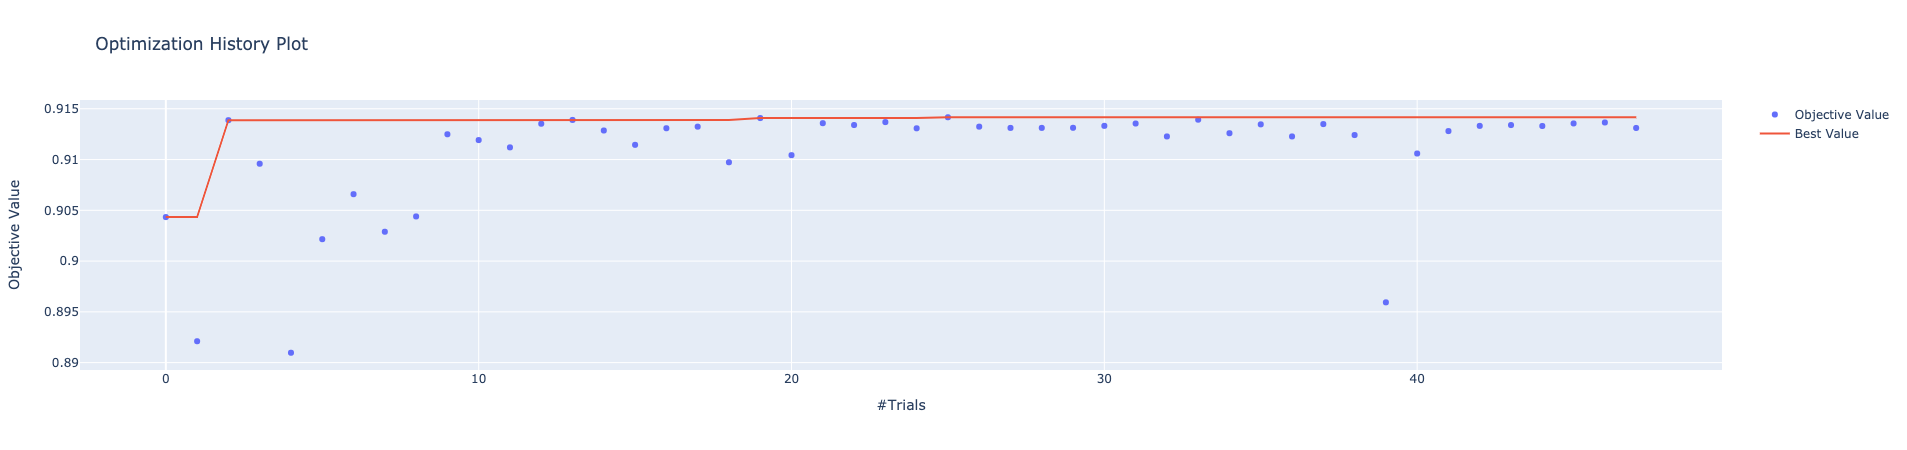

In [121]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [122]:
study.best_params

{'n_blocks': 8, 'lr': 0.0018001684078559576, 'hf': 0.4153062827320591}

In [123]:
study.best_trial

FrozenTrial(number=25, value=0.9141632914543152, datetime_start=datetime.datetime(2021, 7, 24, 13, 34, 44, 299322), datetime_complete=datetime.datetime(2021, 7, 24, 13, 38, 47, 806006), params={'n_blocks': 8, 'lr': 0.0018001684078559576, 'hf': 0.4153062827320591}, distributions={'n_blocks': IntUniformDistribution(high=10, low=1, step=1), 'lr': LogUniformDistribution(high=0.01, low=1e-05), 'hf': UniformDistribution(high=0.5, low=0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=25, state=TrialState.COMPLETE)

In [89]:
with strategy.scope():
    model = ModelResidual(n_blocks = 8)

In [90]:
EPOCHS = 100

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

es_cbk = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=16,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

ck_cbk = tf.keras.callbacks.ModelCheckpoint(
    'model_res',
    monitor="val_auc",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq="epoch",
)

history = model.fit(X_train_qt, y_train_enc,  epochs = EPOCHS, validation_data = (X_valid_qt, y_valid_enc), batch_size = BATCH_SIZE,
                   callbacks = [es_cbk, ck_cbk], verbose=1)

Epoch 1/100
876/879 [============================>.] - ETA: 0s - loss: 0.4450 - auc: 0.8538
Epoch 00001: val_auc improved from -inf to 0.89672, saving model to model_res
879/879 [==============================] - 7s 8ms/step - loss: 0.4448 - auc: 0.8540 - val_loss: 0.3793 - val_auc: 0.8967
Epoch 2/100
878/879 [============================>.] - ETA: 0s - loss: 0.3944 - auc: 0.8877
Epoch 00002: val_auc improved from 0.89672 to 0.90239, saving model to model_res
879/879 [==============================] - 7s 8ms/step - loss: 0.3944 - auc: 0.8877 - val_loss: 0.3697 - val_auc: 0.9024
Epoch 3/100
877/879 [============================>.] - ETA: 0s - loss: 0.3843 - auc: 0.8939
Epoch 00003: val_auc improved from 0.90239 to 0.90479, saving model to model_res
879/879 [==============================] - 7s 7ms/step - loss: 0.3843 - auc: 0.8939 - val_loss: 0.3654 - val_auc: 0.9048
Epoch 4/100
872/879 [============================>.] - ETA: 0s - loss: 0.3793 - auc: 0.8968
Epoch 00004: val_auc improved